In [11]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def studentpdf(epsilon, nu):
    return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)

def garch(mu, omega, alpha, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    sigma_squared[0] = omega / (1 - alpha - beta)
    for t in range(1, T):
        
        sigma_squared[t] = omega + alpha * (returns[t - 1] - mu) ** 2 + beta * sigma_squared[t - 1]
    return sigma_squared

def negative_log_likelihood_garch(parameters, returns):
    mu, omega, alpha, beta, nu = parameters
    sigmasquared = garch(mu, omega, alpha, beta, returns)
    epsilon = (returns - mu) / np.sqrt(sigmasquared)
    ll = -np.log(np.sqrt(sigmasquared)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)

In [43]:
def asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    sigma_squared[0] = omega / (1 - beta - alpha_pos / 2 - alpha_neg / 2)
    for t in range(1, T):
        epsilon_t = (returns[t-1] - mu) / np.sqrt(sigma_squared[t-1])
        shock_effect = alpha_pos * (epsilon_t**2) if epsilon_t >= 0 else alpha_neg * (epsilon_t**2)
        sigma_squared[t] = omega + shock_effect + beta * sigma_squared[t-1]
    return sigma_squared

def neg_log_likelihood_asymmetric_garch(parameters, returns):
    mu, omega, alpha_pos, alpha_neg, beta, nu = parameters
    sigma_squared = asymmetric_garch([mu, omega, alpha_pos, alpha_neg, beta], returns)
    epsilon = (returns - mu) / np.sqrt(sigma_squared)
    LL = -np.log(np.sqrt(sigma_squared)) + np.log(stats.t.pdf(epsilon, df=nu))
    return -np.sum(LL)

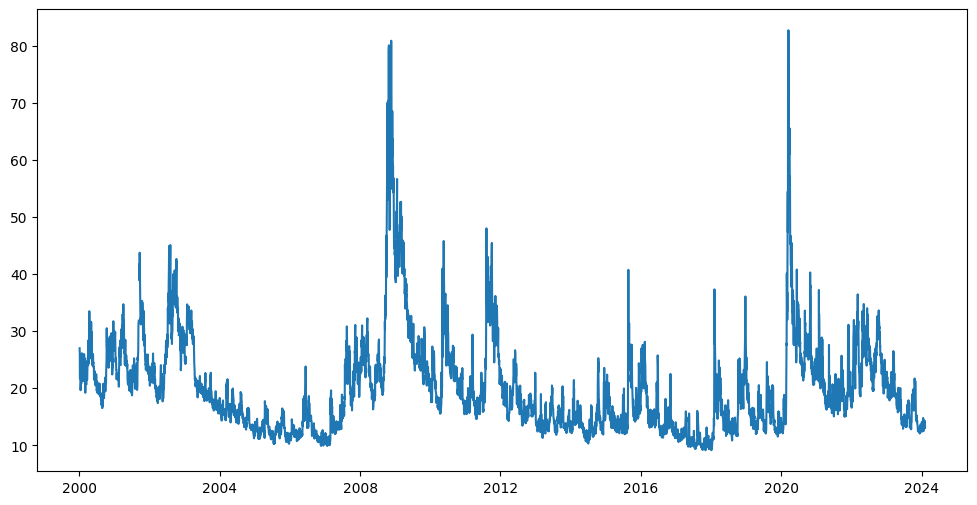

In [26]:
data = pd.read_excel('data.xlsx', index_col='date', parse_dates=True)
returns = data['close-to-close log  return'].values
dates = pd.to_datetime(data.index, format='%Y%m%d')

plt.figure(figsize=(12,6))
plt.plot(data['VIX close']);

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_89173/100303643.py:25: RuntimeWarning: divide by zero encountered in divide
  epsilon = (returns - mu) / np.sqrt(sigmasquared)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_89173/100303643.py:26: RuntimeWarning: divide by zero encountered in log
  ll = -np.log(np.sqrt(sigmasquared)) + np.log(studentpdf(epsilon, nu))
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_89173/100303643.py:26: RuntimeWarning: invalid value encountered in add
  ll = -np.log(np.sqrt(sigmasquared)) + np.log(studentpdf(epsilon, nu))
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_89173/100303643.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_89173/100303643.py:9: RuntimeWarning: invalid value encountered in multiply
  ret

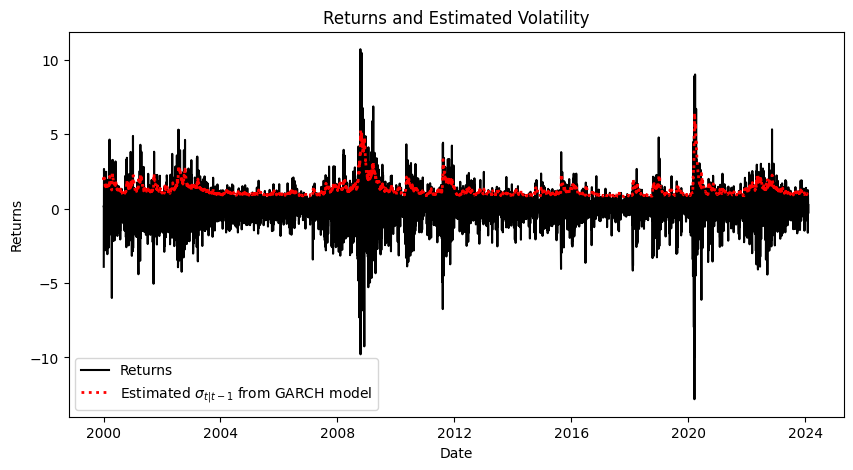

In [37]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(negative_log_likelihood_garch, initial_values, args=(returns,), bounds=bounds)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat, beta_hat, nu_hat = result.x
sigmasquared = garch(mu_hat, omega_hat, alpha_hat, beta_hat, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), 'r:', linewidth=2, label='Estimated $\sigma_{t|t-1}$ from GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()

In [45]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(negative_log_likelihood_garch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat, beta_hat, nu_hat = result.x
sigmasquared = garch(mu_hat, omega_hat, alpha_hat, beta_hat, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), 'r:', linewidth=2, label='Estimated $\sigma_{t|t-1}$ from Asymetric GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_89173/100303643.py:25: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigmasquared)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_89173/100303643.py:26: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigmasquared)) + np.log(studentpdf(epsilon, nu))
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_89173/100303643.py:25: RuntimeWarning: divide by zero encountered in divide
  epsilon = (returns - mu) / np.sqrt(sigmasquared)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_89173/100303643.py:26: RuntimeWarning: divide by zero encountered in log
  ll = -np.log(np.sqrt(sigmasquared)) + np.log(studentpdf(epsilon, nu))
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_89173/100303643.py:26: RuntimeWarning: invalid value encountered in add
  ll = -np.log(np.sqrt(sigmasquared)) + np.log(studentpdf(epsilon, nu))


NameError: name 'garch' is not defined

In [44]:
result

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [ 6.405e-02  7.494e-02  9.999e-02  8.799e-01  6.000e+00]
      nit: 1
      jac: [-2.396e+01  6.331e+03  2.518e+03  6.468e+03  3.117e+01]
     nfev: 30
     njev: 5
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [36]:
result.x

array([0.07559337, 0.01346098, 0.12116175, 0.8757485 , 6.46969495])

In [39]:
result.fun

nan